In [1]:
from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import time

physical_devices = tf.config.list_physical_devices('GPU') 
#for device in physical_devices:
#    tf.config.experimental.set_memory_growth(device, True)
    
#mirrored_strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


## Classifing data with ResNet50

### Create dataset

In [2]:
img_size = 64
num_classes = 25

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "aug-malevis",
    validation_split=0.3,
    subset="training",
    image_size=(img_size,img_size),
    seed=123,
    label_mode='categorical',
    batch_size=256,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "aug-malevis",
    validation_split=0.3,
    subset="validation",
    image_size=(img_size,img_size),
    seed=123,
    label_mode='categorical',
    batch_size=256,
)

train_ds = train_ds.map(lambda x, y: (tf.keras.applications.resnet.preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (tf.keras.applications.resnet.preprocess_input(x), y))

Found 24894 files belonging to 25 classes.
Using 17426 files for training.
Found 24894 files belonging to 25 classes.
Using 7468 files for validation.


In [3]:
from tensorflow import keras

resNet=tf.keras.applications.ResNet152(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size,img_size,3),
)

resNet.trainable=False

model = keras.Sequential()
model.add(resNet)
model.add(layers.Flatten())
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 2, 2, 2048)        58370944  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              8193000   
_________________________________________________________________
dense_1 (Dense)              (None, 25)                25025     
Total params: 66,588,969
Trainable params: 8,218,025
Non-trainable params: 58,370,944
_________________________________________________________________


In [4]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
#model.load_weights('best_resnet.h5')

In [5]:
tic = time.time()

#with mirrored_strategy.scope():
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc', 'Precision', 'Recall', 'AUC', f1_m])
    
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-3, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-3, verbose=1)
'''
best_resnet = tf.keras.callbacks.ModelCheckpoint(
                                          filepath='best_resnet.h5',
                                          save_weights_only=False,
                                          monitor='val_acc',
                                          mode='max',
                                          save_best_only=True)
'''

history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[early_stopping, reduce_lr])

print("Training time:", time.strftime("%H:%M:%S", time.gmtime(time.time() - tic)))

Epoch 1/100
69/69 [==============================] - 37s 296ms/step - loss: 1.5705 - acc: 0.8031 - precision: 0.8688 - recall: 0.7654 - auc: 0.9577 - f1_m: 0.8115 - val_loss: 0.2864 - val_acc: 0.9239 - val_precision: 0.9609 - val_recall: 0.8977 - val_auc: 0.9950 - val_f1_m: 0.9285
Epoch 2/100
69/69 [==============================] - 17s 235ms/step - loss: 0.1662 - acc: 0.9528 - precision: 0.9759 - recall: 0.9352 - auc: 0.9982 - f1_m: 0.9545 - val_loss: 0.2073 - val_acc: 0.9466 - val_precision: 0.9661 - val_recall: 0.9306 - val_auc: 0.9957 - val_f1_m: 0.9481
Epoch 3/100
69/69 [==============================] - 17s 234ms/step - loss: 0.0852 - acc: 0.9766 - precision: 0.9859 - recall: 0.9676 - auc: 0.9996 - f1_m: 0.9769 - val_loss: 0.1948 - val_acc: 0.9488 - val_precision: 0.9616 - val_recall: 0.9395 - val_auc: 0.9959 - val_f1_m: 0.9517
Epoch 4/100
69/69 [==============================] - 17s 233ms/step - loss: 0.0379 - acc: 0.9913 - precision: 0.9947 - recall: 0.9869 - auc: 0.9999 - f1_m

Training accuracy: 1.0
Validation accuracy: 0.957953929901123

Training loss: 0.001801683334633708
Validation loss: 0.19081813097000122


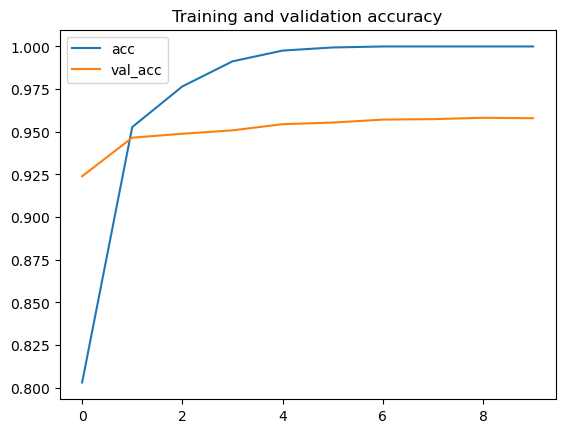

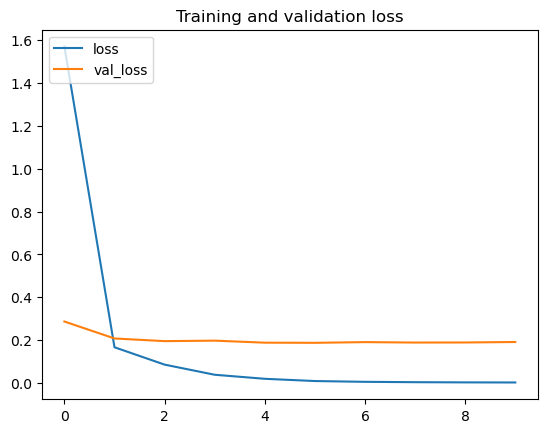

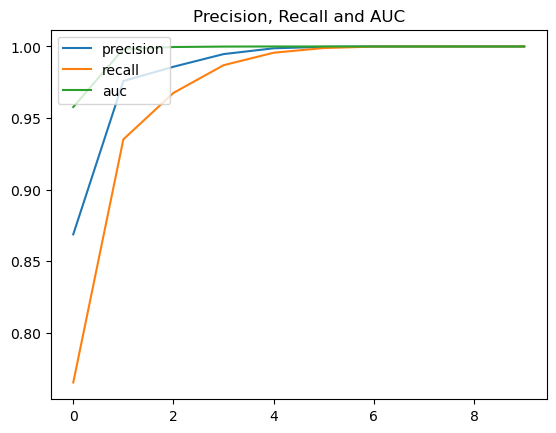

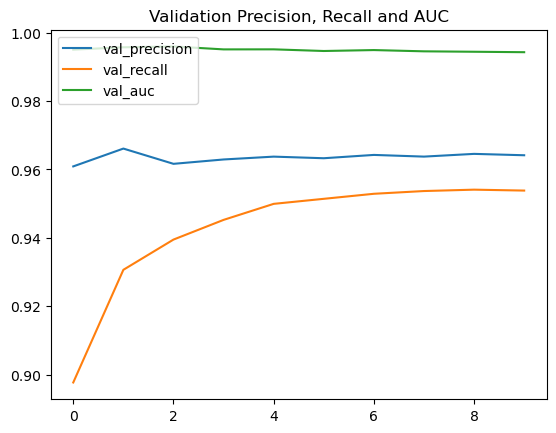

In [6]:
#Plot loss and accuracy as a function of the epoch, for the training and validation datasets.
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
prec = history.history['precision']
rec = history.history['recall']
auc = history.history['auc']
val_prec = history.history['val_precision']
val_rec = history.history['val_recall']
val_auc = history.history['val_auc']


# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.legend(['acc', 'val_acc'], loc='upper left')
print("Training accuracy:", acc[-1])
print("Validation accuracy:", val_acc[-1])
    
# Plot training and validation loss per epoch
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.legend(['loss', 'val_loss'], loc='upper left')
print("\nTraining loss:", loss[-1])
print("Validation loss:", val_loss[-1])

plt.figure()
plt.plot(epochs, prec)
plt.plot(epochs, rec)
plt.plot(epochs, auc)
plt.title('Precision, Recall and AUC')
plt.legend(['precision', 'recall', 'auc'], loc='upper left')

plt.figure()
plt.plot(epochs, val_prec)
plt.plot(epochs, val_rec)
plt.plot(epochs, val_auc)
plt.title('Validation Precision, Recall and AUC')
plt.legend(['val_precision', 'val_recall', 'val_auc'], loc='upper left')

plt.show()

In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "fake-malevis",
    image_size=(img_size,img_size),
    label_mode='categorical',
)

test_ds = test_ds.map(lambda x, y: (tf.keras.applications.resnet.preprocess_input(x), y))

results = model.evaluate(test_ds)

Found 12500 files belonging to 25 classes.
391/391 [==============================] - 27s 67ms/step - loss: 0.0833 - acc: 0.9752 - precision: 0.9787 - recall: 0.9721 - auc: 0.9987 - f1_m: 0.9753
